# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings_Augmented/variational_autoencoder_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.768418  0.105806  0.052689  0.191041 -0.067970  0.100714   
      201547 -0.252496 -0.026617 -0.172014  0.199596  0.011250  0.586043   
      201548 -0.062797  0.288782 -0.203792  0.512605 -0.542463  0.141975   
      201549 -0.202742  0.487075  0.236161 -0.256451  0.061085 -0.071052   
      201550  0.078705  0.337524  0.353719 -0.022176 -0.717527 -0.100617   

                     6         7         8         9  ...      1015      1016  \
41001 201546  0.324865 -0.437571 -0.242084  0.110407  ...  0.270532 -0.756170   
      201547  0.166487  0.050484  0.582742 -0.185948  ...  0.139628  0.141142   
      201548  0.254958 -0.424835 -0.060568  0.305532  ...  0.144593 -0.115399   
      201549 -0.207792  0.081896  0.159953 -0.129235  ... -0.018807 -0.162967   
      201550  0.184612 -0.566448  0.690060 -0.430169  ...  0.104475  0.029885   

                  1017      1018      1019      1020      1021      1022  \
41001 201546 -0.287763 -0.111736  1.000000 -0.157236  0.124462  0.008995   
      201547  0.109197 -0.010110 -0.258921 -0.278923 -0.230450 -0.418045   
      201548  0.043834 -0.543310  0.008144 -0.314908 -0.273801 -0.663290   
      201549  0.546886  0.137912  0.656752  0.228832  0.477480 -0.663369   
      201550 -0.002057 -0.003918 -0.140566  0.513128  0.054067 -0.265198   

                  1023    Labels  
41001 201546 -0.267467 -0.861740  
      201547  0.352616 -0.854589  
      201548  0.229207 -0.856973  
      201549 -0.013687 -0.856973  
      201550 -0.283932 -0.823600  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820  0.741212  0.437213  0.233277 -0.237892  0.306412  0.031602   
      201821 -0.795958 -0.319823 -0.150863 -0.126982 -0.334161  0.542016   
      201822  0.024699  0.398786  0.315063  0.454359  0.259151 -0.605193   
      201823  0.216102 -0.188410  0.433242 -0.047437  0.400394  0.489891   
      201824 -0.081546  0.658736  0.297933 -0.145834 -0.466031 -0.354084   

                     6         7         8         9  ...      1015      1016  \
41001 201820  0.045000 -0.495603  0.226627  0.125265  ...  0.084050 -0.060327   
      201821  0.099369 -0.903839  0.035702 -0.113360  ... -0.514373 -0.189079   
      201822 -0.253066 -0.124082 -0.276288 -0.092569  ...  0.097515  0.142166   
      201823  0.225183 -0.002982 -0.451124  0.068298  ...  0.083698 -0.743087   
      201824 -0.117138 -0.265769  0.358479 -0.110671  ...  0.016737 -0.149395   

                  1017      1018      1019      1020      1021      1022  \
41001 201820  0.162619 -0.372936  0.027451 -0.079414 -0.609911  0.074416   
      201821 -0.007689  0.086586 -0.133838  0.080472  0.226403  0.157502   
      201822  0.776992  0.296445 -0.359342 -0.110119 -0.089291 -0.587660   
      201823 -0.005105 -0.223805  0.418767  0.092784 -0.186568 -0.203780   
      201824  0.693945  0.677619 -0.638988  0.418720 -0.137077 -0.113835   

                  1023    Labels  
41001 201820  0.668683 -0.949940  
      201821 -0.280283 -0.961859  
      201822  0.303453 -0.940405  
      201823  0.029186 -0.961859  
      201824 -0.468916 -0.954708  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 1025)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 1024)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 1024)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

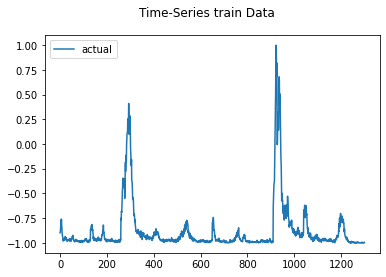

2023-03-13 21:23:53.182665: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-13 21:23:53.182720: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 21:23:53.182752: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-13 21:23:53.183030: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 21:23:53.286527: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 38.543
Test RMSE: 47.479
Test sMAPE: 98.246
Test R Squared: -1.333
{'mae': 38.543031600027376, 'rmse': 47.478504822453154, 'smape': 98.24601067235135, 'r2': -1.332577431395769}


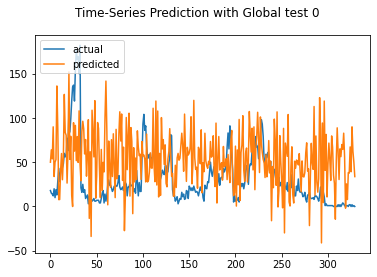

Test MAE: 33.147
Test RMSE: 42.482
Test sMAPE: 94.605
Test R Squared: -0.867
{'mae': 33.14653541174802, 'rmse': 42.48225380838126, 'smape': 94.60520336849876, 'r2': -0.867484905680312}


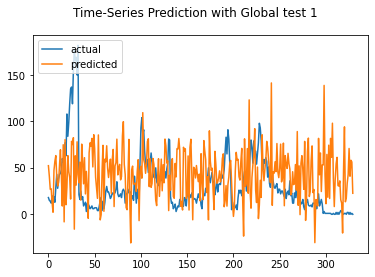

Test MAE: 53.960
Test RMSE: 61.396
Test sMAPE: 107.079
Test R Squared: -2.901
{'mae': 53.959670356548195, 'rmse': 61.39597322847849, 'smape': 107.07910632325515, 'r2': -2.900513431637075}


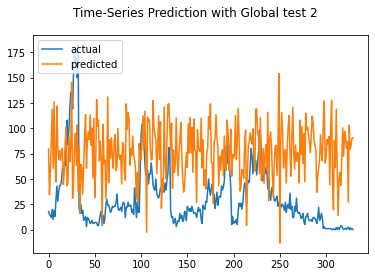

Test MAE: 34.322
Test RMSE: 45.254
Test sMAPE: 113.829
Test R Squared: -1.119
{'mae': 34.32197674151623, 'rmse': 45.254373567059396, 'smape': 113.82935830804541, 'r2': -1.119156920504793}


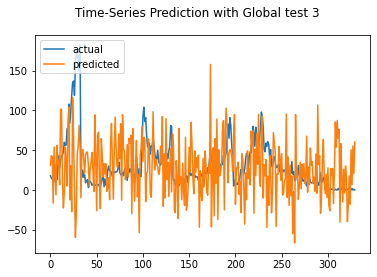

Test MAE: 33.299
Test RMSE: 43.046
Test sMAPE: 97.033
Test R Squared: -0.917
{'mae': 33.29925407929854, 'rmse': 43.04631788295816, 'smape': 97.03300668958954, 'r2': -0.9174057200387893}


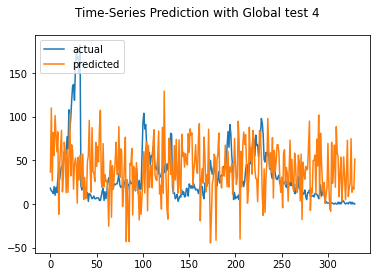

Test MAE: 43.186
Test RMSE: 53.898
Test sMAPE: 103.450
Test R Squared: -2.006
{'mae': 43.18606948635795, 'rmse': 53.89819500177121, 'smape': 103.44979740727865, 'r2': -2.006010161384303}


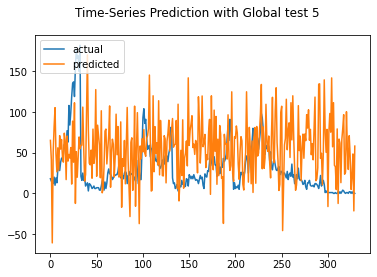

Test MAE: 50.616
Test RMSE: 59.230
Test sMAPE: 104.263
Test R Squared: -2.630
{'mae': 50.61629639647224, 'rmse': 59.23014552626613, 'smape': 104.2629374191, 'r2': -2.630175329721079}


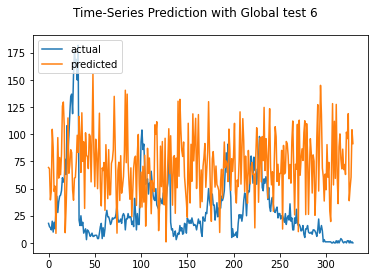

Test MAE: 47.286
Test RMSE: 56.591
Test sMAPE: 104.801
Test R Squared: -2.314
{'mae': 47.28561014587229, 'rmse': 56.59126691169914, 'smape': 104.80073416026946, 'r2': -2.3139109563741256}


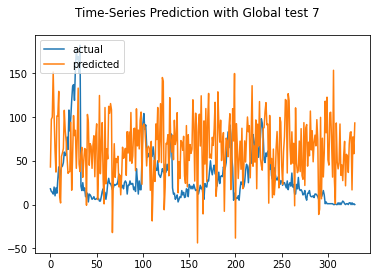

Test MAE: 35.545
Test RMSE: 44.618
Test sMAPE: 107.036
Test R Squared: -1.060
{'mae': 35.54547159888528, 'rmse': 44.61822044808033, 'smape': 107.0355680767168, 'r2': -1.0599965426031632}


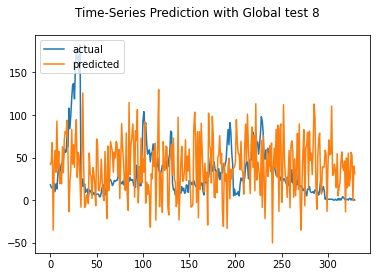

Test MAE: 41.237
Test RMSE: 51.045
Test sMAPE: 101.242
Test R Squared: -1.696
{'mae': 41.236808668573694, 'rmse': 51.0452032202111, 'smape': 101.24245876159411, 'r2': -1.6961985821907124}


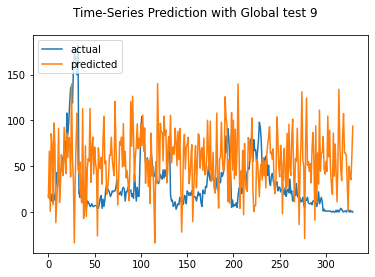

Test MAE: 38.396
Test RMSE: 47.938
Test sMAPE: 98.485
Test R Squared: -1.378
{'mae': 38.39627005168886, 'rmse': 47.93815226145801, 'smape': 98.48536819176738, 'r2': -1.37796020591811}


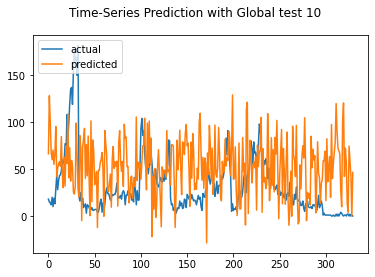

Test MAE: 47.374
Test RMSE: 56.425
Test sMAPE: 105.268
Test R Squared: -2.295
{'mae': 47.373703261577724, 'rmse': 56.42548200661916, 'smape': 105.26788971961686, 'r2': -2.294523099870496}


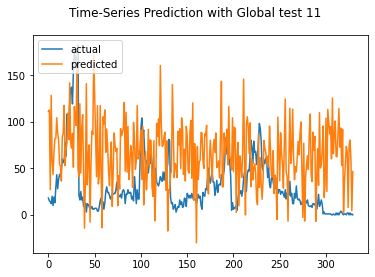

Test MAE: 51.248
Test RMSE: 59.128
Test sMAPE: 106.088
Test R Squared: -2.618
{'mae': 51.24768305475062, 'rmse': 59.127749745346996, 'smape': 106.08788626467982, 'r2': -2.617634643609643}


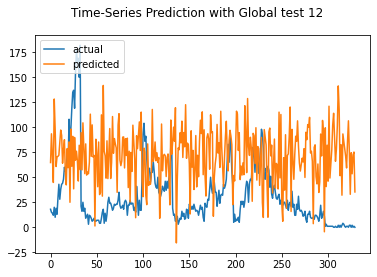

Test MAE: 49.822
Test RMSE: 59.110
Test sMAPE: 105.518
Test R Squared: -2.615
{'mae': 49.822036977247755, 'rmse': 59.1096074967038, 'smape': 105.51824178946018, 'r2': -2.6154149765834256}


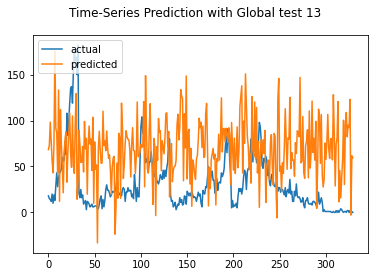

Test MAE: 51.278
Test RMSE: 58.809
Test sMAPE: 105.998
Test R Squared: -2.579
{'mae': 51.27751812212395, 'rmse': 58.809455666939684, 'smape': 105.99804086545804, 'r2': -2.578790871869168}


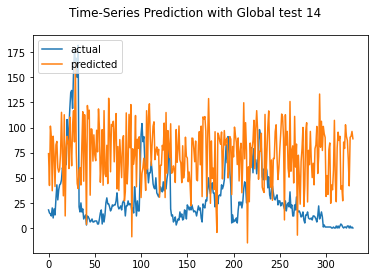

Test MAE: 48.358
Test RMSE: 57.994
Test sMAPE: 102.836
Test R Squared: -2.480
{'mae': 48.35791353637522, 'rmse': 57.99405555057382, 'smape': 102.8357920199061, 'r2': -2.480238139627923}


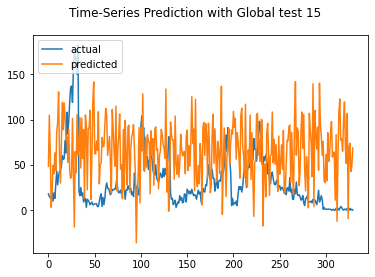

Test MAE: 60.645
Test RMSE: 70.475
Test sMAPE: 111.343
Test R Squared: -4.139
{'mae': 60.64460066493714, 'rmse': 70.47456603185861, 'smape': 111.34268306980529, 'r2': -4.139333754105258}


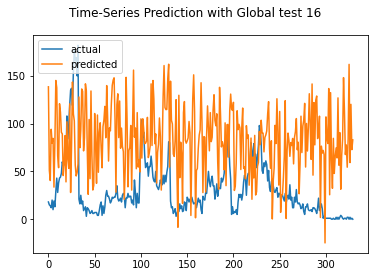

Test MAE: 45.681
Test RMSE: 55.081
Test sMAPE: 103.616
Test R Squared: -2.139
{'mae': 45.68089963053212, 'rmse': 55.0809754480342, 'smape': 103.615736515238, 'r2': -2.1393898304527115}


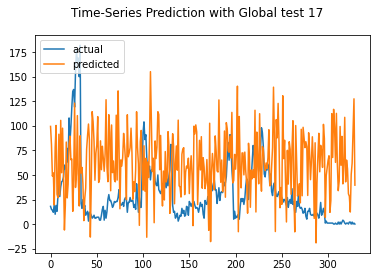

Test MAE: 44.957
Test RMSE: 53.426
Test sMAPE: 102.408
Test R Squared: -1.954
{'mae': 44.956987363822535, 'rmse': 53.425524254317004, 'smape': 102.40835846456545, 'r2': -1.9535177599024052}


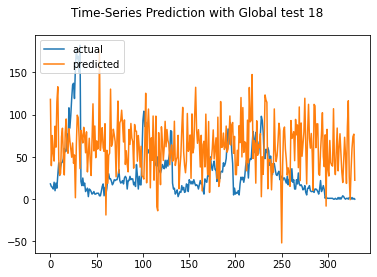

Test MAE: 41.999
Test RMSE: 49.928
Test sMAPE: 99.187
Test R Squared: -1.579
{'mae': 41.999103569261955, 'rmse': 49.92756669013859, 'smape': 99.18660804598744, 'r2': -1.5794243931153922}


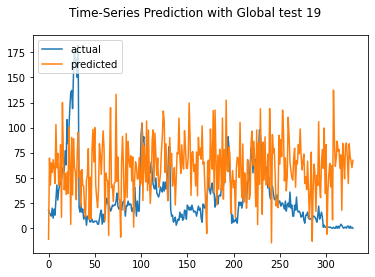

In [ ]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]


calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')